In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

In [2]:
def init(*,iT=30,iNt=3000,iout_time=0.5,icoarsening=2,iR=1,iL=100,iNr=21,iNx=21,iD=0.01,iflow_rate=100/6,irho=1e5):
    '''Modify parameters of problem'''
    global T,Nt,out_time,coarsening,R,L,Nr,Nx,D,flow_rate,rho,dt,dr,dx,Nout,conc,new_conc,surface,flow_time
    T,Nt,out_time,coarsening,R,L,Nr,Nx,D,flow_rate,rho = iT,iNt,iout_time,icoarsening,iR,iL,iNr,iNx,iD,iflow_rate,irho
    dt = T/Nt # simulation time step
    dr = R/(Nr-1) # simulation radial step
    dx = L/(Nx-1) # simulation length step
    Nout = int(out_time/dt) # number of time steps between each output
    conc = np.zeros((Nx,Nr)) # Bacterial concentration within the flow (mm^-3) indexed [i,j] as length and radius respectively
    new_conc = np.zeros((Nx,Nr)) # Bacterial concentration within the flow (mm^-3) at the next time step
    surface = np.zeros(Nx) # Flux through the catheter wall in current time step (mm^-2 s^-1)
    flow_time = (np.pi*R**2)/flow_rate # Time taken on average for fluid to travel 1 mm (s)
    
init() # Initialise with default parameters
sns.set_palette(sns.dark_palette("sky blue", n_colors=6, input="xkcd", reverse=True))
%matplotlib notebook

In [3]:
def step():
    '''Solve the PDE problem for one time-step'''
    c1 = D*dt/(dr*dr)
    c2 = 2*flow_rate*dt/(np.pi*R**4*dx)
    c3 = 1-2*c1
    c7b = c2*R*R
    c8b = c3-c7b
    global conc
    global new_conc
    global surface
    # Main loop
    # Loop over radius
    for j in range(1,Nr-1):
        c4 = 0.5/j
        c5 = c1*(1+c4)
        c6 = c1*(1-c4)
        c7 = c2*(R*R-j*j*dr*dr)
        c8 = c3-c7
        # Loop over length
        for i in range(1,Nx):
            new_conc[i][j] = c5*conc[i][j+1]+c6*conc[i][j-1]+c7*conc[i-1][j]+c8*conc[i][j]
        # boundary condition i=0 (top of catheter)
        new_conc[0][j] = c5*conc[0][j+1]+c6*conc[0][j-1]+c7*rho+c8*conc[0][j]
    # boundaries
    # Boundary condition j=Nr-1, do nothing (keep at zero)
    # Boundary condition i=j=0 (top centre)
    new_conc[0][0] = 2*c1*conc[0][1]+c7b*rho+c8b*conc[0][0]
    for i in range(1,Nx):
        # Boundary condition j=0 (centre of catheter) 
        new_conc[i][0] = 2*c1*conc[i][1]+c7b*conc[i-1][0]+c8b*conc[i][0]
        # Update surface
        surface[i] = D*conc[i][Nr-2]/dr
    # Update surface at i=0
    surface[0] = D*conc[0][Nr-2]/dr
    # Update arrays
    conc, new_conc = new_conc, conc
    # Sanity check 
    if np.max(abs(conc-new_conc))>10*rho:
        raise ValueError("Solution diverging")
            

<IPython.core.display.Javascript object>


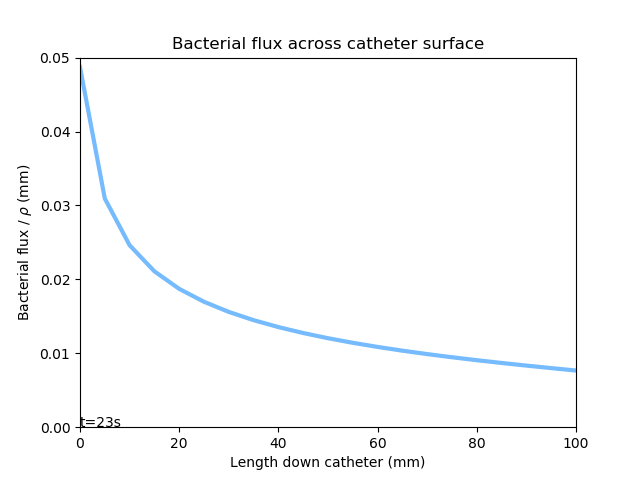

In [4]:
# Animations
fig = plt.figure()
ax = plt.axes(xlim=(0, L), ylim=(0, 0.05))
line, = ax.plot([], [], lw=3)
time = ax.annotate("t=0s", xy=(0, 0))
def initialise():
    init()
    line.set_data([], [])
    return line, time
def animate(i):
    x = np.linspace(0,L,Nx)
    for s in range(Nout):
        step()
    y = surface/rho
    line.set_data(x,y)
    current_time = "t="+str(int(i*out_time))+"s"
    time.set_text(current_time)
    return line, time
ax.set_title("Bacterial flux across catheter surface")
ax.set_xlabel("Length down catheter (mm)")
ax.set_ylabel(r"Bacterial flux / $\rho$ (mm)")
anim = FuncAnimation(fig, animate, init_func=initialise,
                               frames=int(Nt/Nout), interval=50)#, blit=True)

<IPython.core.display.Javascript object>


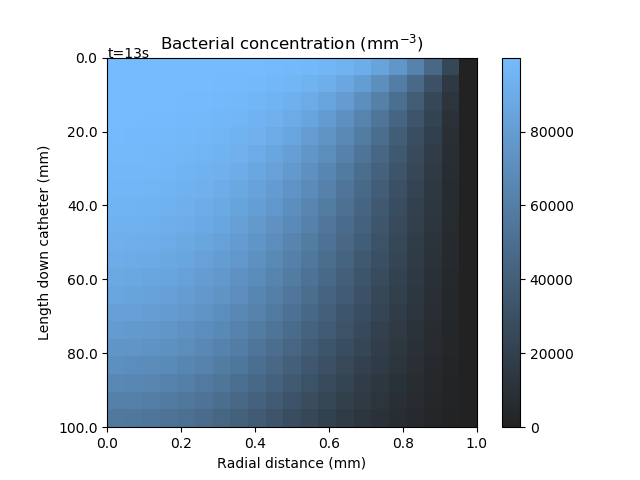

In [5]:
# Animations
fig = plt.figure()
ax = plt.axes()
cmap = sns.dark_palette("sky blue", n_colors=12, input="xkcd", as_cmap=True)
heatmap = ax.imshow(conc, cmap=cmap, extent=[0,10,10,0])
time = ax.annotate("t=0s", xy=(0, 0))
def initialise():
    init()
    heatmap.set_data(conc)
    return heatmap, time
def animate(i):
    for s in range(Nout):
        step()
    heatmap.set_data(conc)
    current_time = "t="+str(int(i*out_time))+"s"
    time.set_text(current_time)
    return heatmap, time
ax.set_title("Bacterial concentration (mm$^{-3}$)")
ax.set_xlabel("Radial distance (mm)")
ax.set_ylabel("Length down catheter (mm)")
ticky = ax.get_xticks()
ax.set_xticklabels([str(i*R/5) for i in range(6)])
ax.set_yticklabels([str(i*L/5) for i in range(6)])
fig.colorbar(heatmap)
anim = FuncAnimation(fig, animate, init_func=initialise,
                               frames=int(Nt/Nout), interval=50)#, blit=True)

In [6]:
# Something to capture timescale. i.e. that the profile stabilises rapidly
# Measure of difference step to step?
# Measure difference relative to the speed at which fluid flows over 1mm

def changing_state():
    flow_steps = max(int(flow_time/dt),1)
    Ntimes = int(Nt/flow_steps)
    diffs = np.zeros(Ntimes)
    old_conc= np.zeros((Nx,Nr)) 
    for t in range(Ntimes):
        try:
            old_conc = conc.copy()
            for i in range(flow_steps):
                step()
            diffs[t]=np.sum(abs(conc-old_conc))
        except ValueError:
            diffs[t]=np.nan
    return diffs/rho 

def steady_time():
    diffs = changing_state()
    return np.where(diffs<0.1)[0][0]*flow_time


<IPython.core.display.Javascript object>


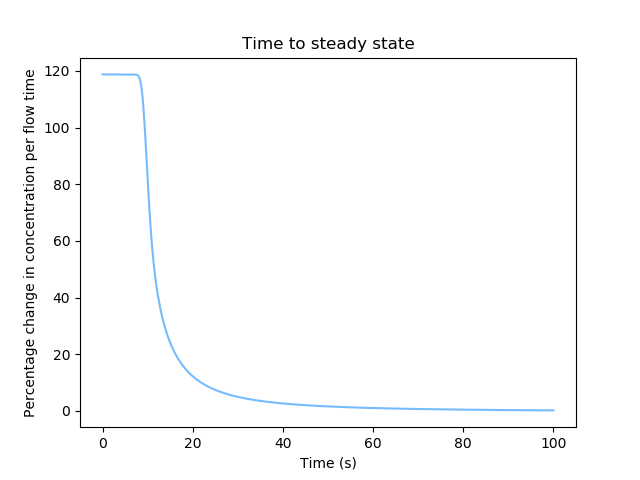

Text(0.5,1,'Time to steady state')

In [42]:
d = [1e-4,1e-3,1e-2,1e-1,1e0,5e-1,1e-5]
init(iD = d[6], iT=100, iNr = 101, iNx = 101)#, iT=0.001, iNt = 6000, iNr = 1001, iNx = 1001)#, iNt = 6000, iT = 5)
plt.figure()
diffs= changing_state()
times = np.linspace(0,T,int(Nt/max(int(flow_time/dt),1)))
plt.plot(times,diffs)
plt.xlabel("Time (s)")
plt.ylabel("Percentage change in concentration per flow time")
plt.title("Time to steady state")

<IPython.core.display.Javascript object>


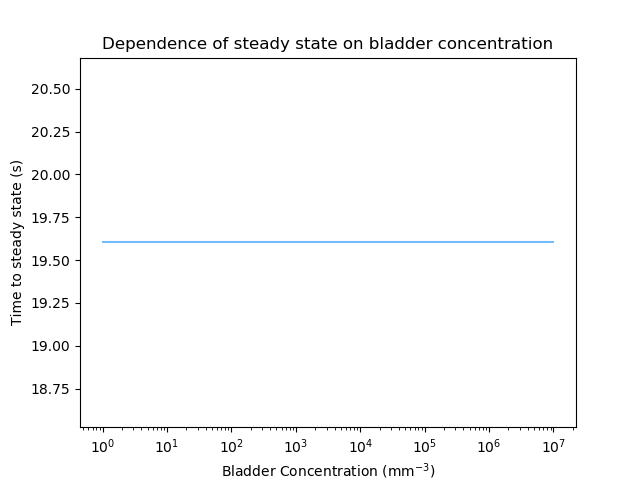

Text(0,0.5,'Time to steady state (s)')

In [8]:
rhos = [1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
val = np.empty_like(rhos)
for i in range(len(rhos)):
    init(irho = rhos[i])
    val[i] = steady_time()
plt.figure()
plt.plot(rhos,val)
plt.xscale('log')
plt.title("Dependence of steady state on bladder concentration")
plt.xlabel(r"Bladder Concentration (mm$^{-3}$)")
plt.ylabel("Time to steady state (s)")

# Dependence of steady state on bladder concentration
There is no dependence of the steady state on the bladder concentration. In fact, altering the bladder concentration is simply linearly scales the entire concentration profile. This is reassuring!

<IPython.core.display.Javascript object>


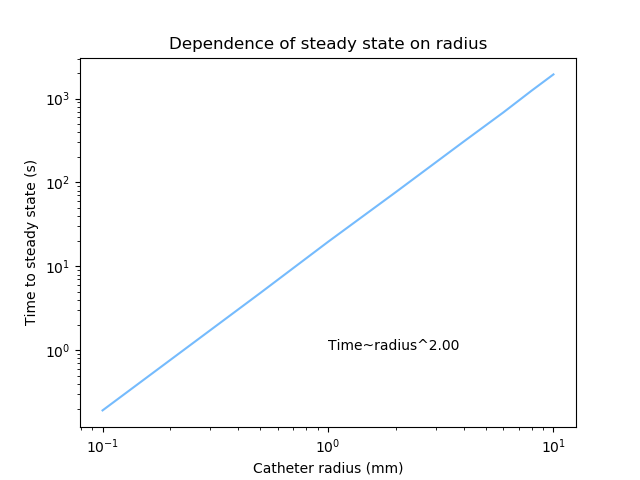

Text(1,1,'Time~radius^2.00')

In [9]:
radii = [0.1,0.2,0.5,1,2,4,6,8,10]
times = [0.5,1,6,30,100,400,800,1400,2100]
rad_val = np.empty_like(radii)
for i in range(len(radii)):
    init(iR = radii[i], iT = times[i])
    rad_val[i] = steady_time()
plt.figure()
plt.loglog(radii,rad_val)
plt.xlabel("Catheter radius (mm)")
plt.ylabel("Time to steady state (s)")
plt.title("Dependence of steady state on radius")
fit = np.polyfit(np.log(radii), np.log(rad_val), 1)
plt.annotate("Time~radius^{0:.2f}".format(fit[0]), xy=(1, 1))

# Dependence of steady state on radius
The time varies perfectly with the radius squared. This is to be expected given that in the radial direction we are simply considering a diffusion problem.

<IPython.core.display.Javascript object>


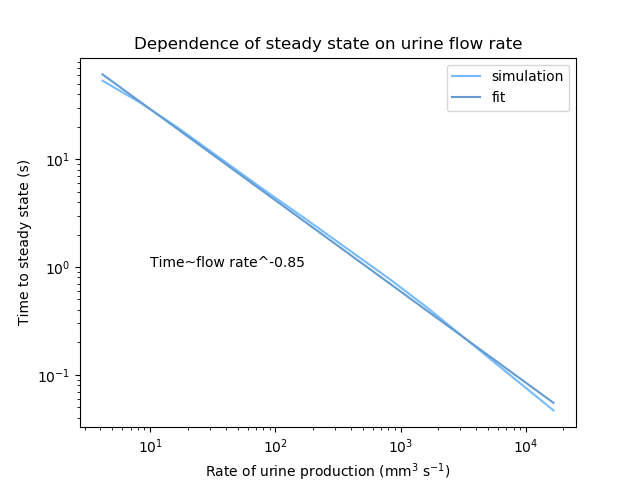

In [10]:
flow_rates = np.array([2.5e1,5e1,1e2,5e2,1e3,5e3,1e4,1e5])*(1/6)
# Anuria if flow rate drops below 100ml per day = 25/6 mm^3 per sec (https://en.wikipedia.org/wiki/Anuria)
times = [70,50,30,10,5,1.2,0.6,0.06]
fval = np.empty_like(flow_rates)
for i in range(len(flow_rates)):
    init(iflow_rate = flow_rates[i], iT = times[i])
    fval[i] = steady_time()
plt.figure()
plt.loglog(flow_rates,fval, label="simulation")
plt.title("Dependence of steady state on urine flow rate")
plt.xlabel(r"Rate of urine production (mm$^3$ s$^{-1}$)")
plt.ylabel("Time to steady state (s)")
fit = np.polyfit(np.log(flow_rates), np.log(fval), 1)
plt.annotate("Time~flow rate^{0:.2f}".format(fit[0]), xy=(10, 1))
poly = np.poly1d(fit)
yfit = lambda x: np.exp(poly(np.log(x)))
plt.plot(flow_rates,yfit(flow_rates), label="fit")
plt.legend()

# Dependence of steady state on flow rate
It looks like for very high flow rates there is an inverse relation time~flow^-1.
As the flow rate decreases boundary effects become more important and this relation tails off. We see the steady state being achieved earlier than we would have expected from the linear relationship.
The physically relevant range is from 25/6 mm^3 s^-1 to 2500/6 mm^3 s^-1. I.e. from 15 ml hr^-1 to 1.5 L hr^-1.

In [33]:
np.polyfit(np.log(diffusivities[:6]), dval[:6], 1)

array([-4.61715515, -1.85211913])

<IPython.core.display.Javascript object>


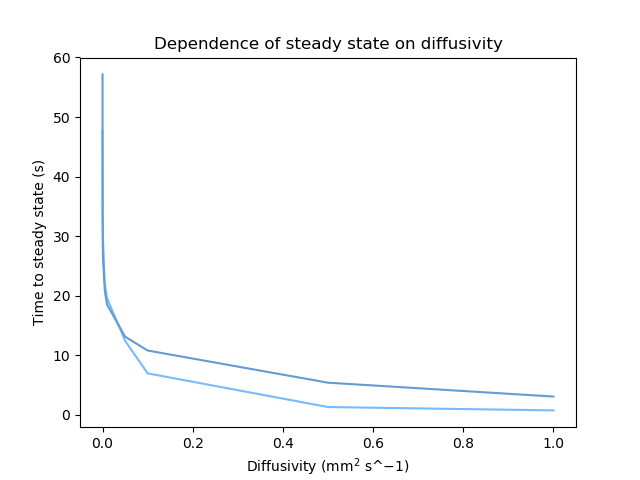

In [39]:
diffusivities = [1e-7,1e-6,1e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1e0]
times = [90,90,60,60,60,45,45,30,30,10,3,2]
dval = np.empty_like(diffusivities)
for i in range(len(diffusivities)):
    init(iD = diffusivities[i], iT = times[i])
    dval[i] = steady_time()
plt.figure()
plt.plot(diffusivities,dval)
plt.xlabel(r"Diffusivity (mm$^2$ s^${-1}$)")
plt.ylabel("Time to steady state (s)")
plt.title("Dependence of steady state on diffusivity")
fit = np.polyfit(np.log(diffusivities), dval, 1)
plt.plot(diffusivities,np.poly1d(fit)(np.log(diffusivities)))
#plt.annotate("Time~radius^{0:.2f}".format(fit[0]), xy=(1, 1))

In [ ]:
# Comparing fluxes
rhos = [1e0,1e1,1e2,1e3,1e4,1e5]
radii = [1,2,5,10]
flow_rates = np.array([1e0,1e1,1e2,1e3,1e4,1e5])*(1/6)
diffusivities = [1e-4,1e-3,1e-2,1e-1,1e0,1e1]

def flux_calculator():
    for s in range(Nt):
        step()
    return surface/rho

In [ ]:
plt.figure()
ax = plt.axes(xlim=(0, L), ylim=(0, 0.05))
x = np.linspace(0,L,Nx)
for i in range(len(rhos)):
    init(irho = rhos[i])
    y = flux_calculator()
    ax.plot(x,y,label=r"$\rho$ = {}".format(rho))
plt.legend()
ax.set_title(r"Bacterial flux across catheter surface for varying $\rho$")
ax.set_xlabel("Length down catheter (mm)")
ax.set_ylabel(r"Bacterial flux / $\rho$ (mm)")

In [ ]:
plt.figure()
ax = plt.axes(xlim=(0, L), ylim=(0, 0.05))
x = np.linspace(0,L,Nx)
for i in range(len(radii)):
    init(iR = radii[i])
    y = flux_calculator()
    ax.plot(x,y,label="Radius = {}".format(R))
plt.legend()
ax.set_title(r"Bacterial flux across catheter surface for varying radius")
ax.set_xlabel("Length down catheter (mm)")
ax.set_ylabel(r"Bacterial flux / $\rho$ (mm)")

In [ ]:
plt.figure()
ax = plt.axes(xlim=(0, L), ylim=(0, 0.05))
x = np.linspace(0,L,Nx)
for i in range(len(flow_rates)):
    init(iflow_rate = flow_rates[i])
    y = flux_calculator()
    ax.plot(x,y,label="Flow rate = {}".format(flow_rate))
plt.legend()
ax.set_title(r"Bacterial flux across catheter surface for varying flow rates")
ax.set_xlabel("Length down catheter (mm)")
ax.set_ylabel(r"Bacterial flux / $\rho$ (mm)")

In [ ]:
plt.figure()
ax = plt.axes(xlim=(0, L), ylim=(0, 0.05))
x = np.linspace(0,L,Nx)
for i in range(len(diffusivities)):
    init(iD = diffusivities[i])
    y = flux_calculator()
    ax.plot(x,y,label="Diffusivity = {}".format(D))
plt.legend()
ax.set_title(r"Bacterial flux across catheter surface for varying diffusivities")
ax.set_xlabel("Length down catheter (mm)")
ax.set_ylabel(r"Bacterial flux / $\rho$ (mm)")

In [ ]:
# Attempting to fit an exponential to the surface flux

init()
y = flux_calculator()

In [ ]:
plt.figure()
ax = plt.axes(xlim=(0, L), ylim=(0, 0.1))
x = np.linspace(0,L,Nx)

ax.plot(x,y,label="Simulation")
ax.plot(x,1e-5*flow_rate**2/(D**2*R**5*x**2)*np.exp(-0.007*(flow_rate)/(D*x)), label="Fit")
ax.set_xlabel("Length down catheter (mm)")
ax.set_ylabel(r"Bacterial flux / $\rho$ (mm)")
plt.legend()

In [ ]:
#All junk/obsolete past this point

In [ ]:
'''Initialise with default parameters'''
T = 30 # Simulation length/runtime (s)
Nt = 3000 # Number of time steps
out_time = 0.5 # time step at which to output results
coarsening = 2 # factor by which to coarsen x,r for ouputting concentration profile
R = 1 # Radius of catheter (mm)
L = 100 # Length of catheter (mm)
Nr = 21 # Number of radial points
Nx = 21 # Number of x points
D = 0.01 # Diffusivity (mm^2 s^-1)
flow_rate = 100/6 # Rate of urine production (mm^3 s^-1)
rho = 1e5 # bacterial concentration in bladder (mm^-3)
dt = T/Nt # simulation time step
dr = R/(Nr-1) # simulation radial step
dx = L/(Nx-1) # simulation length step
Nout = int(out_time/dt) # number of time steps between each output
conc = np.zeros((Nx,Nr)) # Bacterial concentration within the flow (mm^-3) indexed [i,j] as length and radius respectively
new_conc = np.zeros((Nx,Nr)) # Bacterial concentration within the flow (mm^-3) at the next time step
surface = np.zeros(Nx) # Flux through the catheter wall in current time step (mm^-2 s^-1)

In [ ]:
# Open results files
surface_file = open('results_surface.csv','ba')
conc_file = open('results_conc.csv','ba')
surface_file.truncate(0)
conc_file.truncate(0)

In [ ]:
def output():
    # Save surface
    np.savetxt(surface_file, surface, footer='\n',comments='')
    # Save coarsened conc
    np.savetxt(conc_file, conc[::coarsening][::coarsening].flatten(), footer='\n',comments='')

In [ ]:
# Execute code
for t in range(int(Nt/Nout)):
    # Progress simulation
    for s in range(Nout):
        step()
    # output results
    output()

In [ ]:
# Clean up
surface_file.close()
conc_file.close()

In [ ]:
# Animations with seaborn
%matplotlib notebook
fig = plt.figure()
ax = sns.heatmap(conc, vmin=0, vmax=1)
def init():
    plt.clf()
    global conc 
    conc= np.zeros((Nx,Nr)) 
    global new_conc 
    new_conc= np.zeros((Nx,Nr)) 
    global surface 
    surface= np.zeros(Nx) 
    ax = sns.heatmap(conc, vmin=0, vmax=1)

def animate(i):
    plt.clf()
    for s in range(Nout):
        step()
    ax = sns.heatmap(conc, vmin=0, vmax=1)

anim = FuncAnimation(fig, animate, init_func=init, frames=int(Nt/Nout), interval=10, blit=True)


In [ ]:

def old_changing_state():
    diffs = np.zeros(Nt)
    global conc 
    conc= np.zeros((Nx,Nr)) 
    global new_conc 
    new_conc= np.zeros((Nx,Nr)) 
    global surface 
    surface= np.zeros(Nx) 
    for t in range(Nt):
        step()
        diffs[t]=np.sum(abs(conc-new_conc))
    return diffs/rho 